In [1]:
# 주식 종목 불러오는 패키지
!pip install finance-datareader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 5.3 MB/s eta 0:00:00


In [1]:
import FinanceDataReader as fdr

# 삼성전자

In [2]:
# 삼성전자로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('005930', '2024-01-01', '2025-12-31')
df.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2025-07-14,62300,62600,61800,62500,13563846,-0.001597
2025-07-15,62300,63800,62000,63700,18442202,0.019200
2025-07-16,63700,64700,63100,64700,23042660,0.015699
2025-07-17,65900,66800,64400,66700,39448683,0.030912
2025-07-18,67000,67800,66300,67100,23853052,0.005997


# 분석 코드

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# GPU 꼭 연결해서 사용하세요~!
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

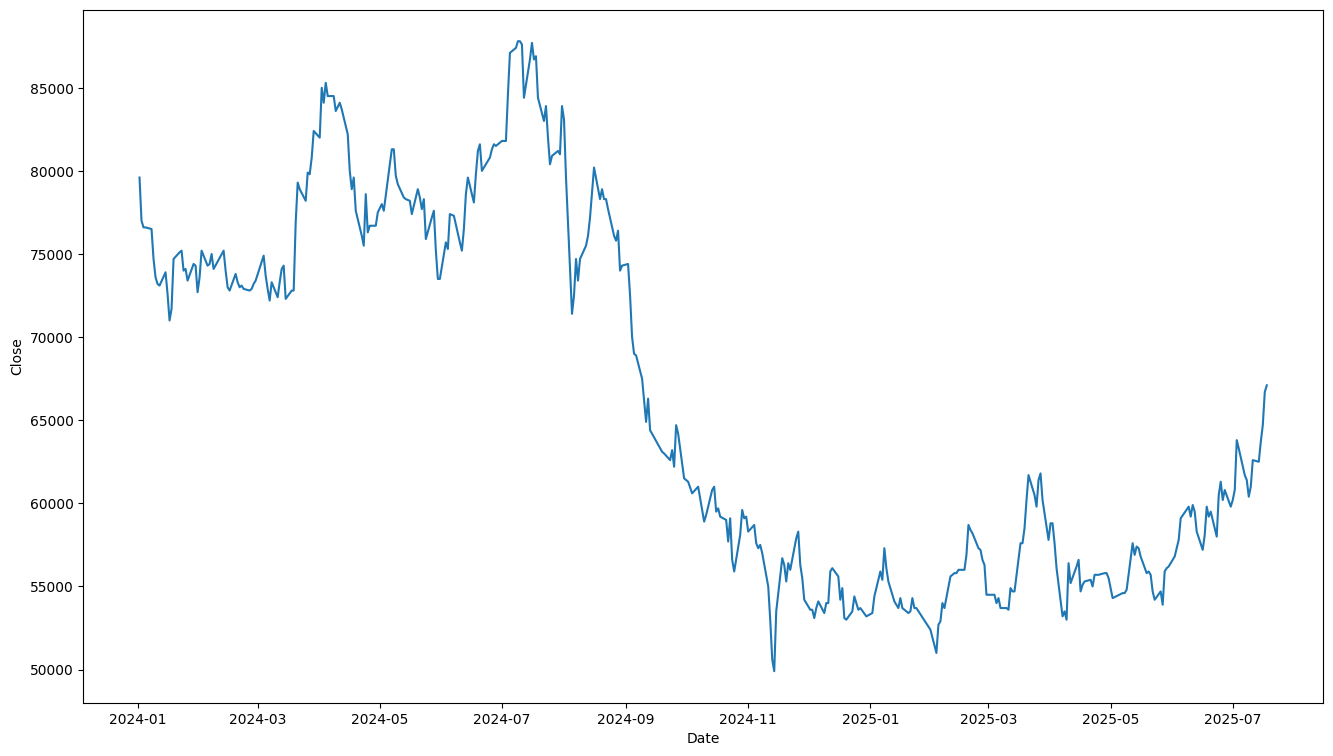

In [5]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=df.index, y='Close', data=df)
plt.show()

# 데이터 전처리

In [6]:
#종가 제외 스케일링 (반응변수 = 종가)
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Volume']] = scaler.fit_transform(df[['Open','High', 'Low','Volume']])

In [7]:
#넘파이 배열로 변경
x = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

#시퀀스 데이터 생성
def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[ i : i + sequence_length])
    y_seq.append(y[i + sequence_length])

  #gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

In [8]:
split = 200
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length)

#순서대로 70개는 학습, 나머지는 평가
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([171, 5, 4]) torch.Size([171, 1])


/tmp/ipython-input-7-483295013.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)


In [9]:
x_train_seq

tensor([[[0.7311, 0.7594, 0.7608, 0.2179],
         [0.7389, 0.7326, 0.7285, 0.3068],
         [0.6762, 0.6925, 0.7043, 0.1828],
         [0.6919, 0.6872, 0.7124, 0.1052],
         [0.6997, 0.6979, 0.7124, 0.1011]],

        [[0.7389, 0.7326, 0.7285, 0.3068],
         [0.6762, 0.6925, 0.7043, 0.1828],
         [0.6919, 0.6872, 0.7124, 0.1052],
         [0.6997, 0.6979, 0.7124, 0.1011],
         [0.7102, 0.7032, 0.6559, 0.3891]],

        [[0.6762, 0.6925, 0.7043, 0.1828],
         [0.6919, 0.6872, 0.7124, 0.1052],
         [0.6997, 0.6979, 0.7124, 0.1011],
         [0.7102, 0.7032, 0.6559, 0.3891],
         [0.6475, 0.6364, 0.6263, 0.2780]],

        ...,

        [[0.2089, 0.1898, 0.1801, 0.4948],
         [0.1514, 0.1471, 0.1586, 0.3854],
         [0.1436, 0.1898, 0.1559, 0.4229],
         [0.2037, 0.2193, 0.1989, 0.4344],
         [0.2324, 0.2246, 0.2339, 0.2699]],

        [[0.1514, 0.1471, 0.1586, 0.3854],
         [0.1436, 0.1898, 0.1559, 0.4229],
         [0.2037, 0.2193, 0.1989

In [10]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 5
# 학습 데이터 로더 생성 (셔플 적용)
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
# 테스트 데이터 로더 생성 (셔플 미적용)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

# Vanila RNN
## 모델 구축

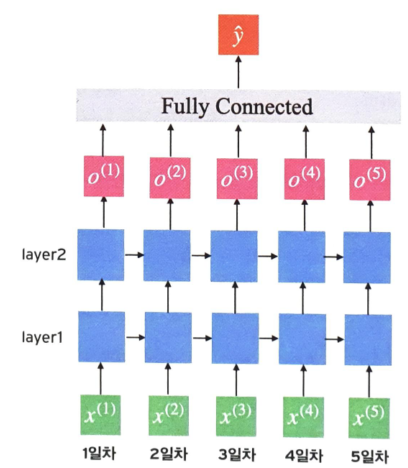

In [11]:
#기본 하이퍼 파라미터 설정
input_size = x_seq.size(2)  #x_seq.size(): dimensions of tensor -> x_seq.size(2): number of features(4)
num_layers = 2
hidden_size = 8

In [12]:
class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) #한 줄로 모델 정의
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid()) #RNN 층에서 나온 결과를 fc 층으로 전달해서 예측값 계산

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) #초기값 0으로 설정
    out,_ = self.rnn(x, h0) #rnn 통과
    out = out.reshape(out.shape[0], -1) #저번 스텝에서 output 가져오기
    out = self.fc(out)
    return out

In [13]:
model = VanillaRNN(input_size=input_size,
                   hidden_size = hidden_size, #hidden unit 8개
                   sequence_length=sequence_length, #시퀀스 길이 5일
                   num_layers=num_layers, #2개
                   device=device).to(device)

In [14]:
criterion = nn.MSELoss()
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 모델 학습

In [15]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0

  for data in train_loader:
    seq, target = data #배치 데이터
    out = model(seq) #출력값 계산
    loss = criterion(out, target) #손실함수 계산

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #최적화
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))

[epoch : 0] loss: 5645668454.4000
[epoch : 10] loss: 5645620454.4000
[epoch : 20] loss: 5645620358.4000
[epoch : 30] loss: 5645620371.2000
[epoch : 40] loss: 5645620377.6000


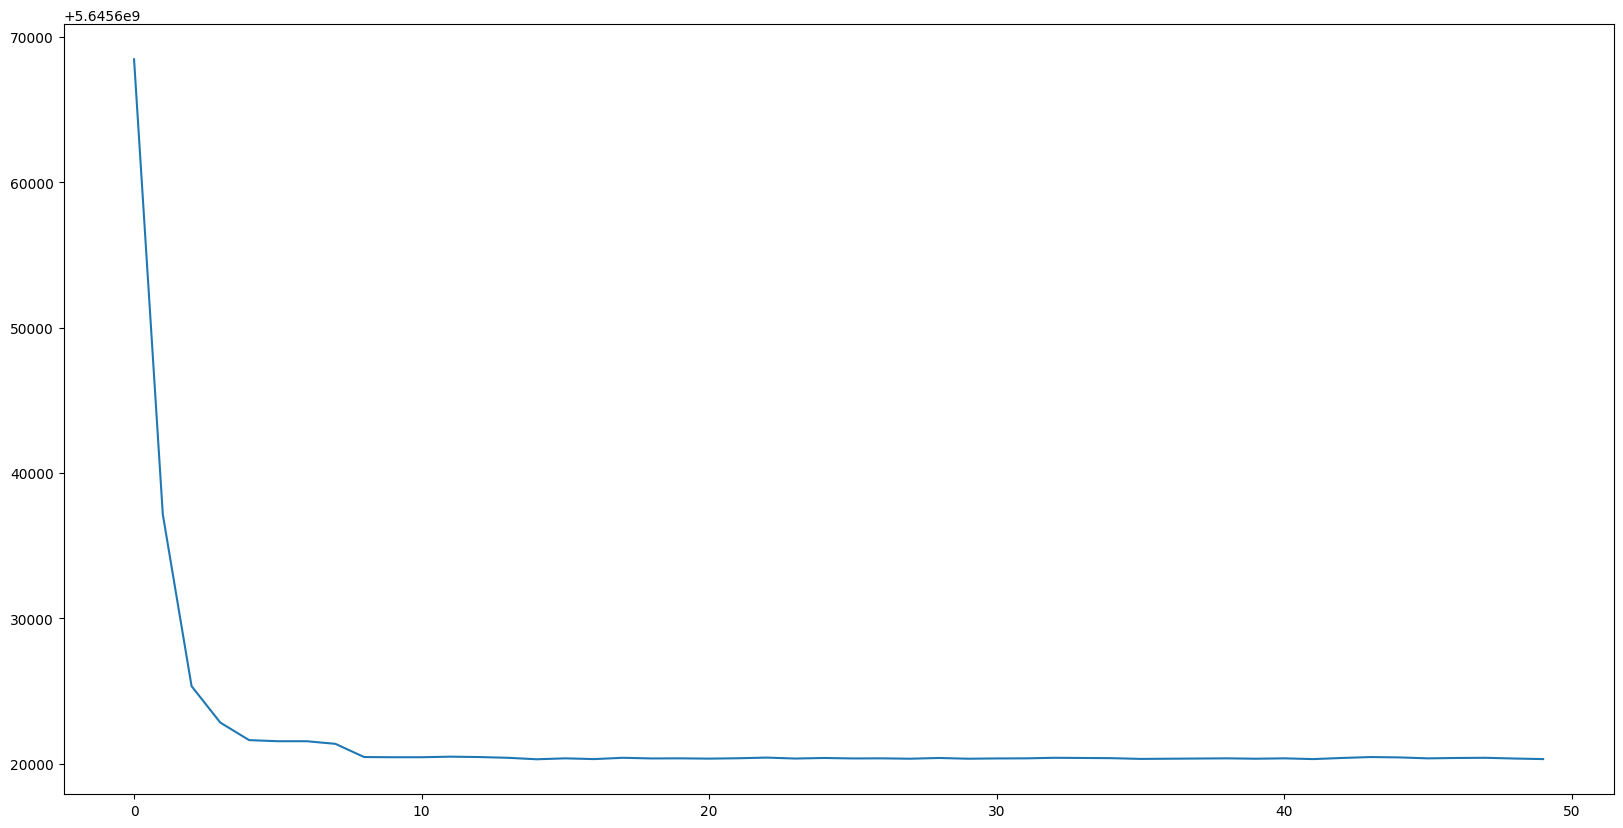

In [16]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

### loss
loss가 지나치게 높게 나옴. scaler가 훈련 데이터에 대해서만 적용되어서 그런 듯하다. 다시 scale 하기..? activation이 sigmoid라 closes에 대해서도 스케일링 필요?

In [41]:
#종가 제외 스케일링 (반응변수 = 종가)
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open','High', 'Low','Close','Volume']])

In [42]:
#넘파이 배열로 변경
x = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

#시퀀스 데이터 생성
def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[ i : i + sequence_length])
    y_seq.append(y[i + sequence_length])

  #gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

In [43]:
split = 200
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length)

#순서대로 70개는 학습, 나머지는 평가
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([171, 5, 4]) torch.Size([171, 1])


In [44]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 5
# 학습 데이터 로더 생성 (셔플 적용)
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
# 테스트 데이터 로더 생성 (셔플 미적용)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

In [45]:
model = VanillaRNN(input_size=input_size,
                   hidden_size = hidden_size, #hidden unit 8개
                   sequence_length=sequence_length, #시퀀스 길이 5일
                   num_layers=num_layers, #2개
                   device=device).to(device)

In [46]:
criterion = nn.MSELoss()
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [47]:
loss_graph = []
n = len(train_loader)

# 모델을 학습 모드로 설정
model.train()

for epoch in range(num_epochs):
  running_loss = 0

  for data in train_loader:
    seq, target = data #배치 데이터
    out = model(seq) #출력값 계산
    loss = criterion(out, target) #손실함수 계산

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #최적화
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))

[epoch : 0] loss: 0.0396
[epoch : 10] loss: 0.0046
[epoch : 20] loss: 0.0041
[epoch : 30] loss: 0.0036
[epoch : 40] loss: 0.0032


- 추가적으로, 원본파일에서는 테스트 데이터가 더 적은데 (~2024.7.31 까지) 지금은 같은 테스트 데이터셋 가지고 더 긴 기간을 예측해야 하는 거 같아서 split 다시 해보기

In [48]:
split = 320
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length)

#순서대로 70개는 학습, 나머지는 평가
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([320, 5, 4]) torch.Size([320, 1])
torch.Size([51, 5, 4]) torch.Size([51, 1])


In [49]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 5
# 학습 데이터 로더 생성 (셔플 적용)
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
# 테스트 데이터 로더 생성 (셔플 미적용)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

In [50]:
model = VanillaRNN(input_size=input_size,
                   hidden_size = hidden_size, #hidden unit 8개
                   sequence_length=sequence_length, #시퀀스 길이 5일
                   num_layers=num_layers, #2개
                   device=device).to(device)

In [51]:
criterion = nn.MSELoss()
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [52]:
loss_graph = []
n = len(train_loader)

# 모델을 학습 모드로 설정
model.train()

for epoch in range(num_epochs):
  running_loss = 0

  for data in train_loader:
    seq, target = data #배치 데이터
    out = model(seq) #출력값 계산
    loss = criterion(out, target) #손실함수 계산

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #최적화
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))

[epoch : 0] loss: 0.0734
[epoch : 10] loss: 0.0037
[epoch : 20] loss: 0.0032
[epoch : 30] loss: 0.0028
[epoch : 40] loss: 0.0023


## 실제값과 예측값 비교

In [53]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)

with torch.no_grad():
  pred = []
  model.eval()
  for data in data_loader:
    seq, target = data
    out = model(seq)
    pred += out.cpu().tolist()

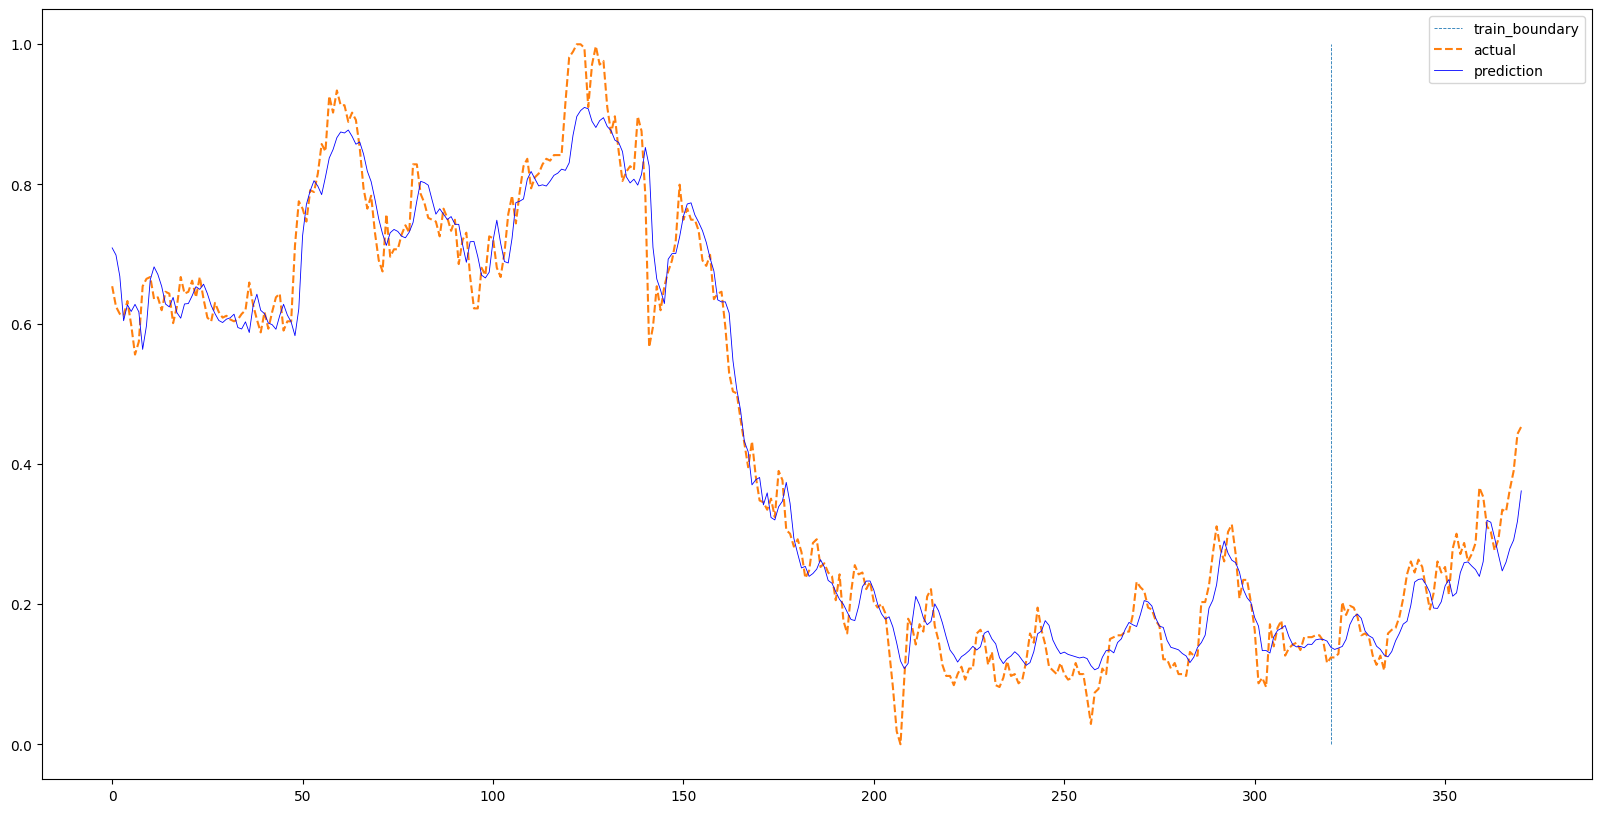

In [54]:
plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred, 'b', linewidth = 0.6)
plt.legend(['train_boundary','actual','prediction'])
plt.show()

# LSTM
## 모델구축

In [55]:
#하이퍼 파라미터 정의
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [56]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size*sequence_length ,1)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ = self.lstm(x,(h0,c0))
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [57]:
model = LSTM(input_size = input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers = num_layers,
             device=device).to(device)

In [58]:
criterion = nn.MSELoss()
num_epochs =50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [59]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))


[epoch: 0] loss: 0.1900
[epoch: 10] loss: 0.0041
[epoch: 20] loss: 0.0036
[epoch: 30] loss: 0.0033
[epoch: 40] loss: 0.0030


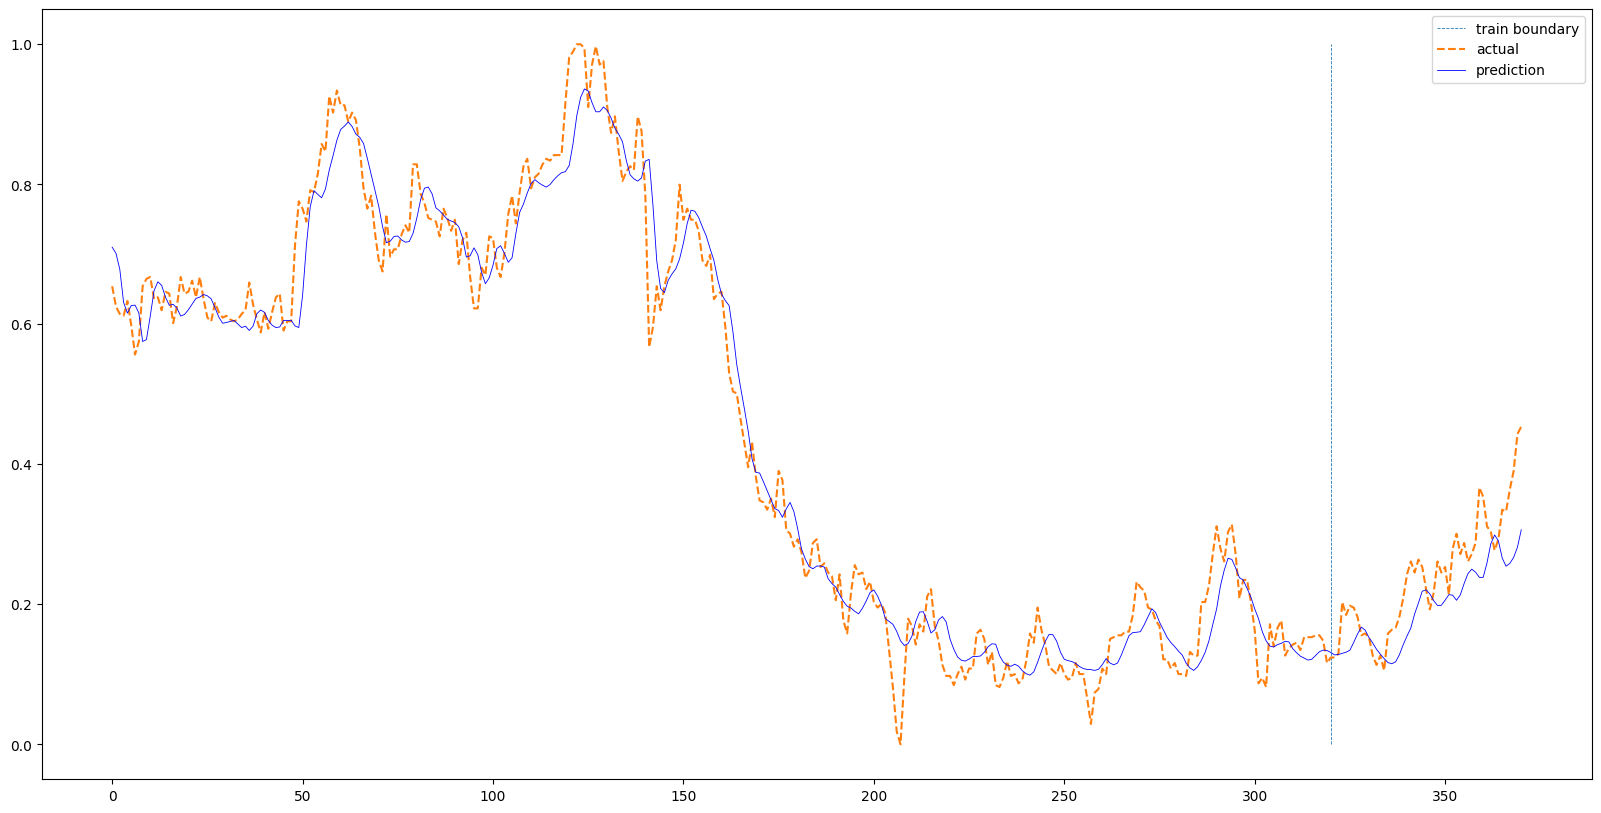

In [60]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b', linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show()

# (Optional)

현대 자동차 주가에 대한 정보에 같은 분석을 해봅시다. 다음 코드를 한 번 실행한 뒤, 분석 코드부터 다시 그대로 돌려보시기 보고 결과에 대해 자유롭게 해석해보시기 바랍니다.

In [62]:
# 현대자동자 주가로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('005380', '2024-01-01', '2025-12-31')
df.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2025-07-14,208500,218000,208000,217000,1241993,0.043269
2025-07-15,217000,217500,209500,211000,1111748,-0.027650
2025-07-16,211000,211000,207500,207500,492782,-0.016588
2025-07-17,208500,212000,205500,210000,611349,0.012048
2025-07-18,210000,212500,208500,210500,317353,0.002381


In [79]:
#종가 제외 스케일링 (예측변수 = 종가)
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open','High', 'Low','Close','Volume']])

#넘파이 배열로 변경
x = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

#시퀀스 데이터 생성
def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[ i : i + sequence_length])
    y_seq.append(y[i + sequence_length])

  #gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

In [147]:
split = 200
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length)

#순서대로 70개는 학습, 나머지는 평가
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([171, 5, 4]) torch.Size([171, 1])


In [148]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 5
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

모델 구축-Vanilla RNN

In [149]:
#기본 하이퍼 파라미터 설정
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [150]:
class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) #한 줄로 모델 정의
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid()) #RNN 층에서 나온 결과를 fc 층으로 전달해서 예측값 계산

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) #초기값 0으로 설정
    out,_ = self.rnn(x, h0) #pass through RNN
    out = out.reshape(out.shape[0], -1) #저번 스텝에서 output 가져오기
    out = self.fc(out)
    return out

In [151]:
model = VanillaRNN(input_size=input_size, #x_seq.size(): dimensions of tensor -> x_seq.size(2): number of features(4)
                   hidden_size = hidden_size, #hidden unit 8개
                   sequence_length=sequence_length, #input sequence 길이 5일
                   num_layers=num_layers, #layer 2개
                   device=device).to(device)

criterion = nn.MSELoss()
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [152]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0

  for data in train_loader:
    seq, target = data #배치 데이터
    out = model(seq) #출력값 계산
    loss = criterion(out, target) #손실함수 계산(MSE 로 설정)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #최적화
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n)) #실행이 잘되는지 확인문구

[epoch : 0] loss: 0.0415
[epoch : 10] loss: 0.0079
[epoch : 20] loss: 0.0059
[epoch : 30] loss: 0.0048
[epoch : 40] loss: 0.0043


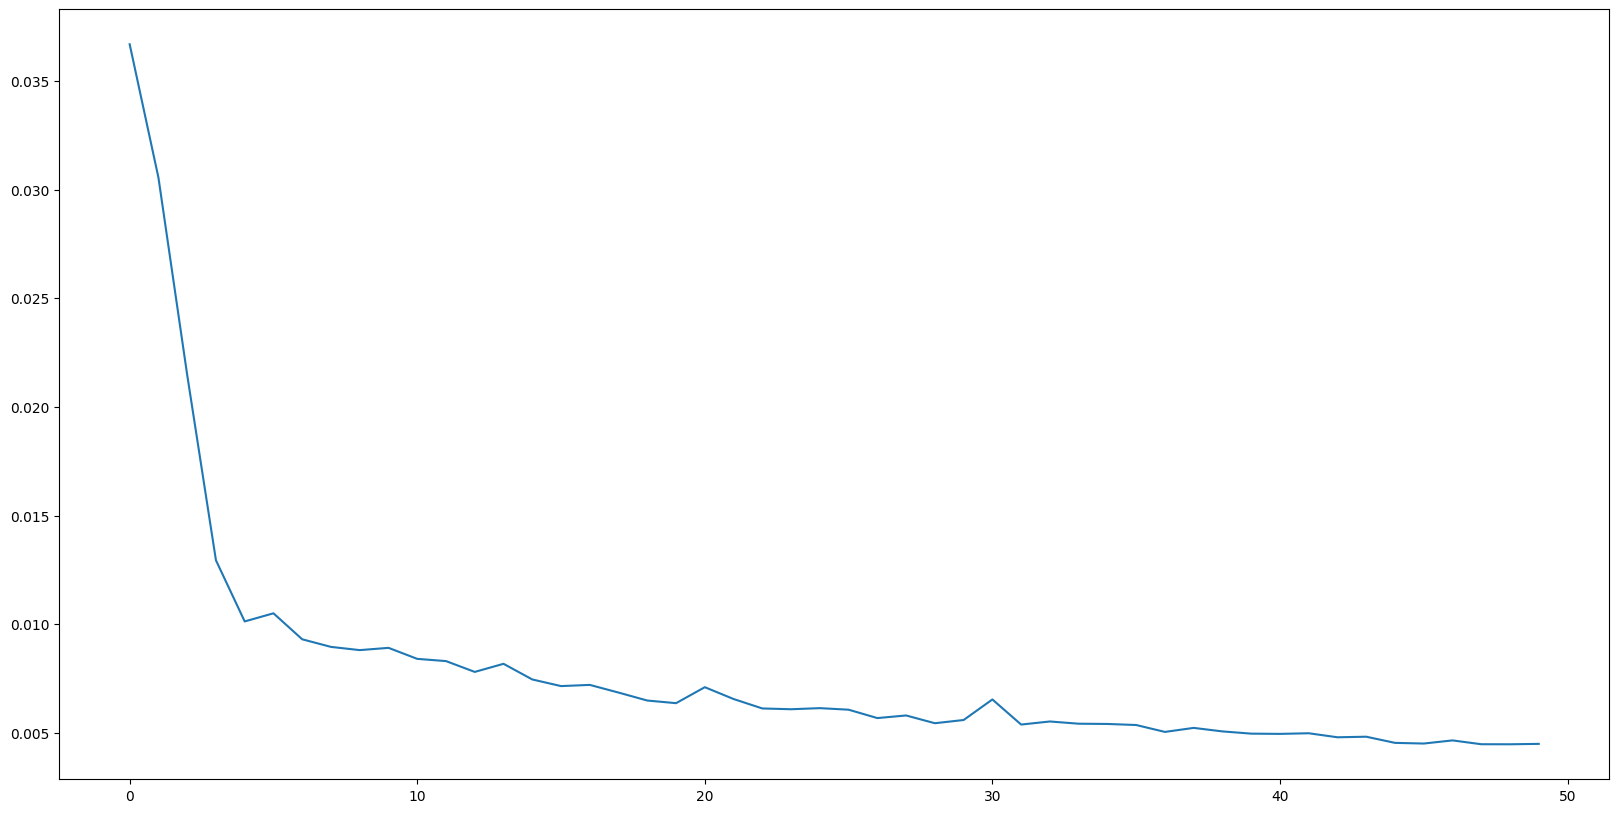

In [100]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

In [101]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)

with torch.no_grad():
  pred = []
  model.eval()
  for data in data_loader:
    seq, target = data
    out = model(seq)
    pred += out.cpu().tolist()

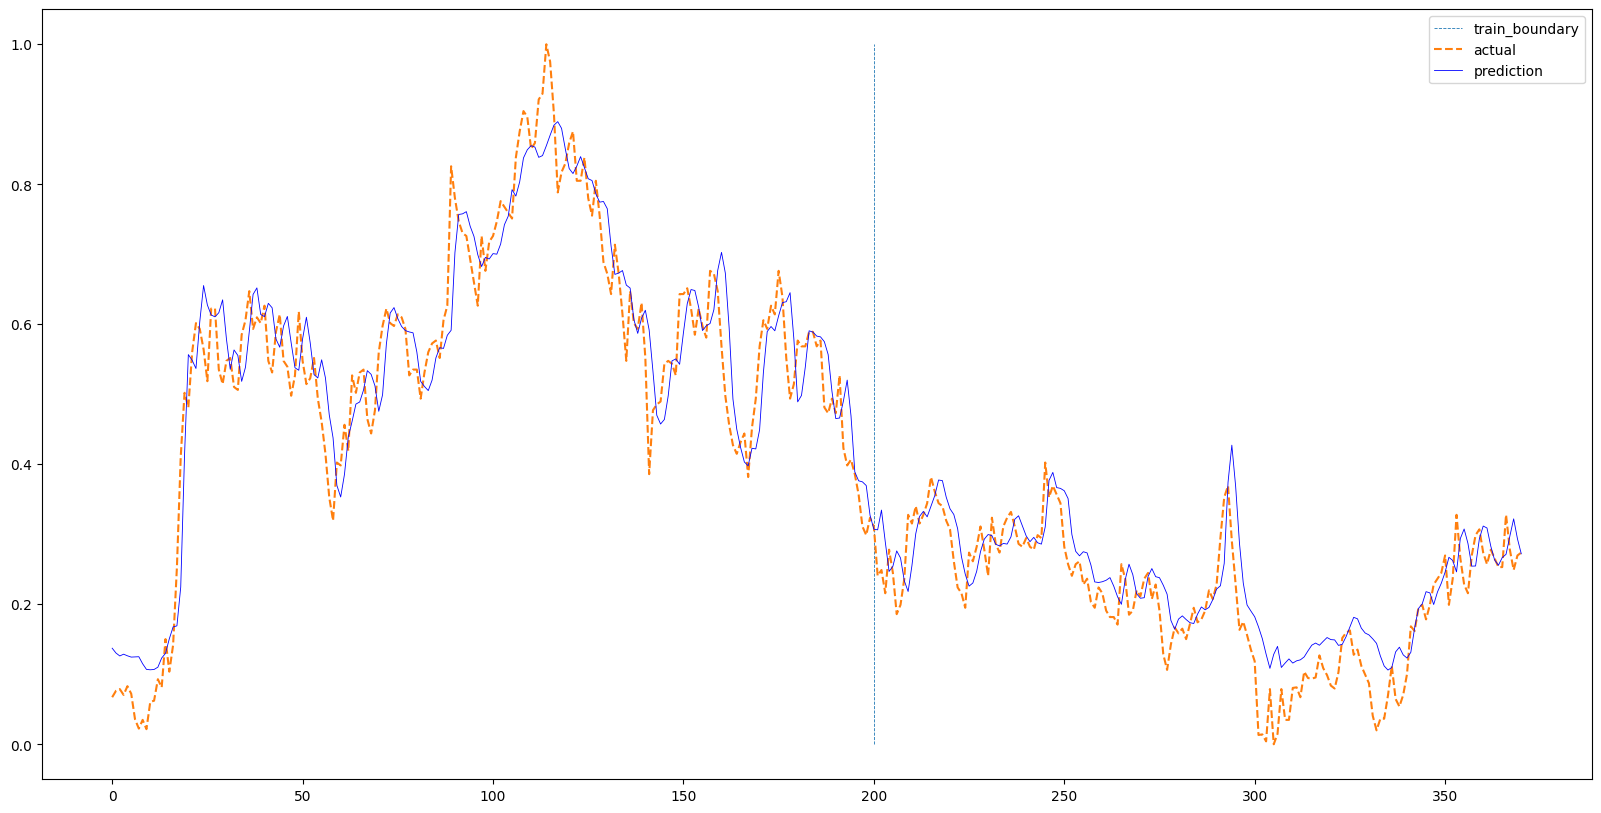

In [102]:
plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred, 'b', linewidth = 0.6)
plt.legend(['train_boundary','actual','prediction'])
plt.show()

모델 구축 - LSTM

In [142]:
#하이퍼 파라미터 정의
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [143]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size*sequence_length ,1)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ = self.lstm(x,(h0,c0))
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [144]:
model = LSTM(input_size = input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers = num_layers,
             device=device).to(device)

criterion = nn.MSELoss()
num_epochs =50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [106]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))

[epoch: 0] loss: 0.4043
[epoch: 10] loss: 0.0083
[epoch: 20] loss: 0.0078
[epoch: 30] loss: 0.0068
[epoch: 40] loss: 0.0064


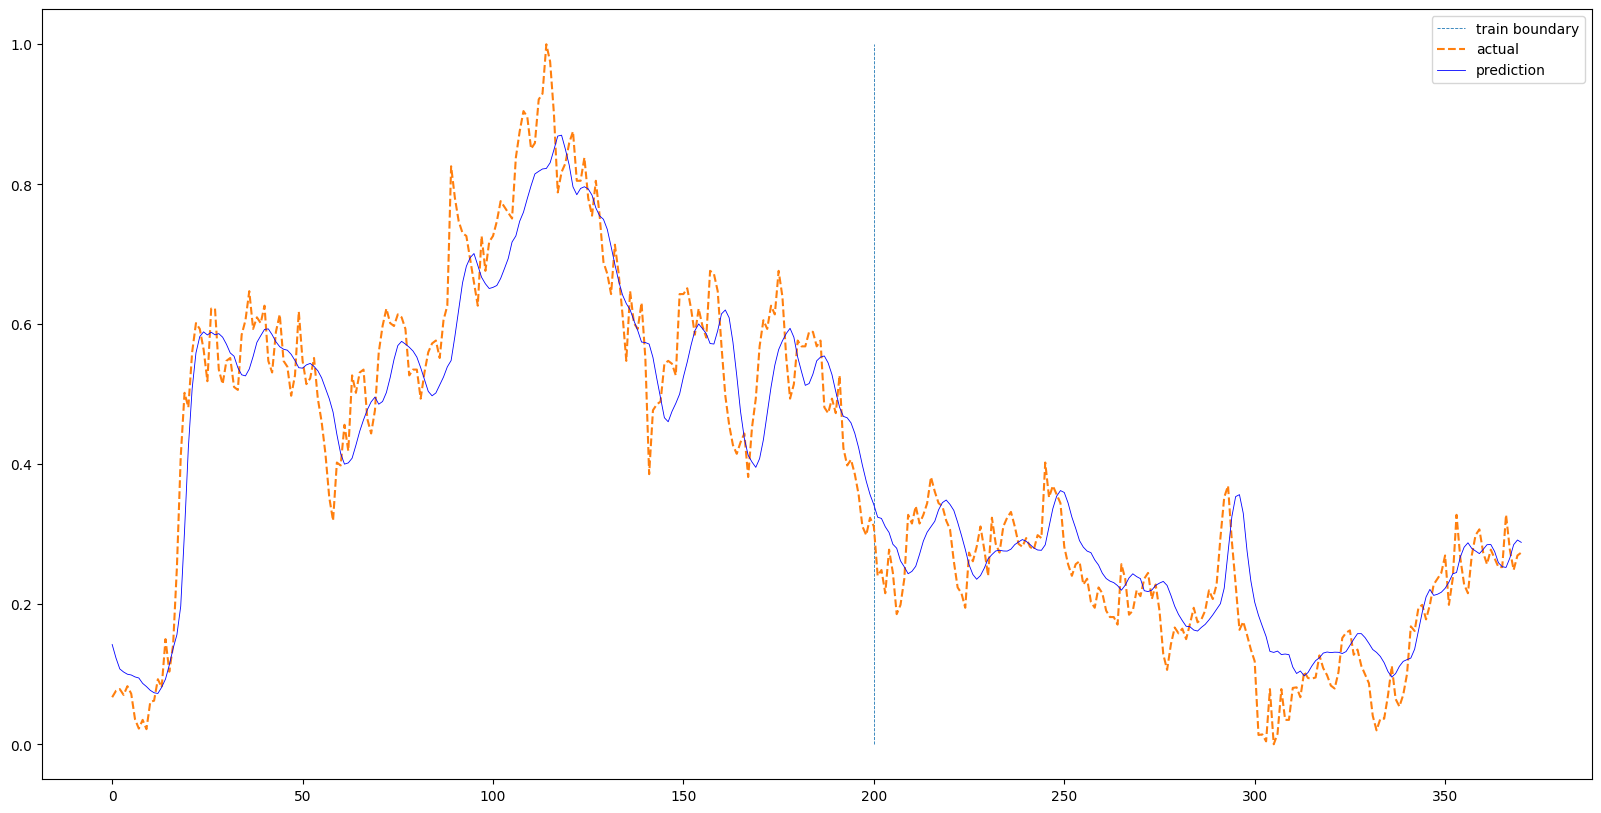

In [107]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b', linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show()

- 현대 자동차에서 train set을 적게 잡은 경우에  train 및 test data 모두에 대해 LSTM보다 Vanilla RNN의 예측 결과가 더 좋다. LSTM이 더 복잡한 구조를 가지고 있으며 게이트를 통해 장기기억을 보존하는 데 도움이 됨에도 불구하고, 이런 결과가 나타난 것은 데이터의 특징으로 인한 것으로 보인다.

훈련 데이터를 조금 제한적으로 설정해두었기에, LSTM 모델이 데이터의 패턴을 충분히 학습하지 못하여 예측 성능이 떨어질 수 있다.

## 훈련 데이터 크기를 키운 경우 (중복 코드는 굳이 다시 안 붙이고 위에서 실행시킴)

In [134]:
split = 320
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length)

#순서대로 70개는 학습, 나머지는 평가
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([320, 5, 4]) torch.Size([320, 1])
torch.Size([51, 5, 4]) torch.Size([51, 1])


In [139]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0

  for data in train_loader:
    seq, target = data #배치 데이터
    out = model(seq) #출력값 계산
    loss = criterion(out, target) #손실함수 계산(MSE 로 설정)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #최적화
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n)) #실행이 잘되는지 확인문구

[epoch : 0] loss: 0.0537
[epoch : 10] loss: 0.0062
[epoch : 20] loss: 0.0043
[epoch : 30] loss: 0.0038
[epoch : 40] loss: 0.0033


In [140]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)

with torch.no_grad():
  pred = []
  model.eval()
  for data in data_loader:
    seq, target = data
    out = model(seq)
    pred += out.cpu().tolist()

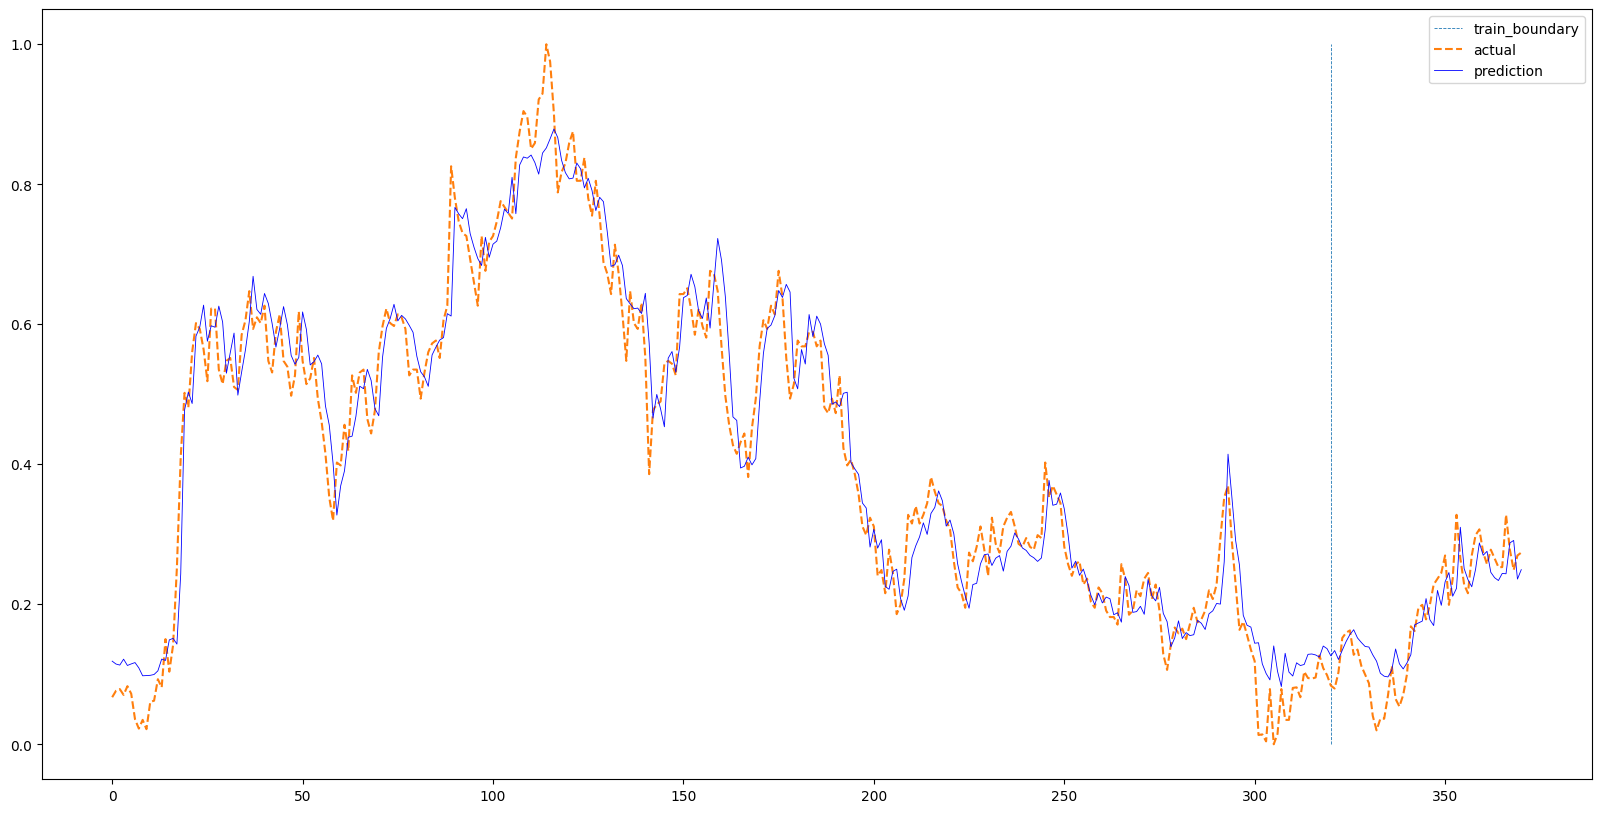

In [141]:
plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred, 'b', linewidth = 0.6)
plt.legend(['train_boundary','actual','prediction'])
plt.show()

In [145]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))

[epoch: 0] loss: 0.0533
[epoch: 10] loss: 0.0060
[epoch: 20] loss: 0.0047
[epoch: 30] loss: 0.0039
[epoch: 40] loss: 0.0033


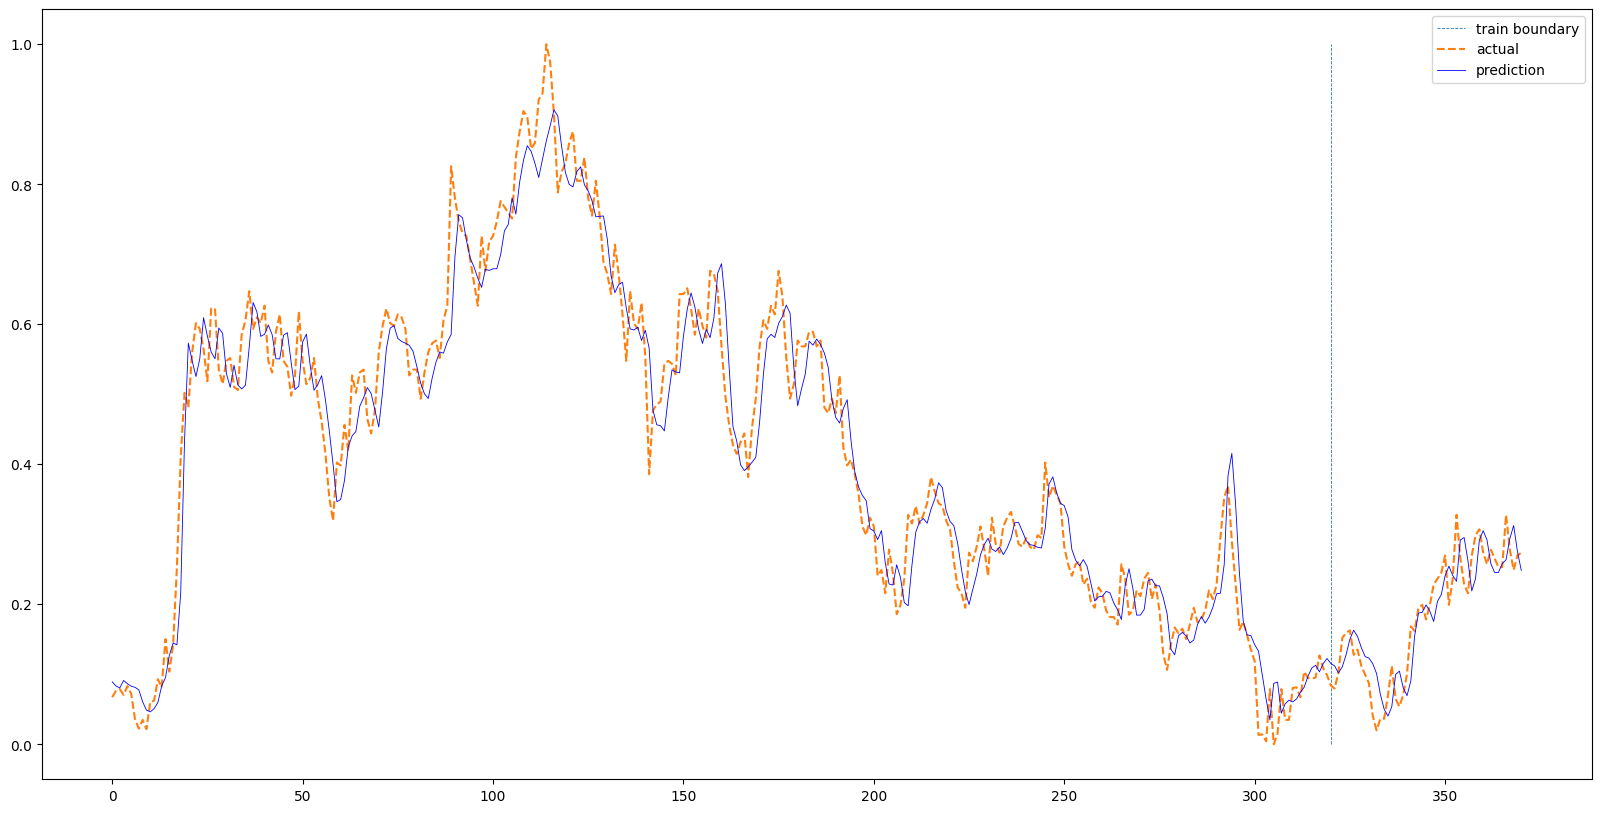

In [146]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b', linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show()

LSTM이 트렌드를 더 잘 따라가는 걸 확인할 수 있다.